In [ ]:
import anthropic

client = anthropic.Anthropic(
    api_key="key",  # Replace with your actual API key
)

response = client.messages.create(
    model="claude-3-7-sonnet-20250219",
    max_tokens=2100,
    thinking={
        "type": "enabled",
        "budget_tokens": 2000
    },
    messages=[{
        "role": "user",
        "content": "Are there an infinite number of prime numbers such that n mod 4 == 3?"
    }]
)

print(response.content[0])
print(response.content[1])


ThinkingBlock(signature='ErUBCkYIAxgCIkCmQTCxMj/mwaT3qYxOLQnGngJ4QG9iydvEhWBJIGGyOjaTkjEW0Q1/56FArn/mXpTFmQkSsP3YFFYGJJA82yDGEgyRydjy8uvdR266/e8aDDUr307Tf9PfbEBAyCIw9wgzuLpvBKxv5NHgrr6hhmZnyywtA6Z2W4Vh+B4TPxfd0xUISr28wPMOLqmtDaQdKh2RZ7nuwB48ZDnbWqPr30VvLRG65lCb8ynoGYdFrBgC', thinking="The question asks whether there are infinitely many prime numbers that leave a remainder of 3 when divided by 4. That is, are there infinitely many primes $p$ such that $p \\equiv 3 \\pmod{4}$?\n\nLet's think about this. These would be primes of the form $p = 4k + 3$ for some non-negative integer $k$. \n\nExamples would include:\n$3 = 4 \\cdot 0 + 3$\n$7 = 4 \\cdot 1 + 3$\n$11 = 4 \\cdot 2 + 3$\n$19 = 4 \\cdot 4 + 3$\n$23 = 4 \\cdot 5 + 3$\n\nSo the question is whether this sequence of primes continues infinitely.\n\nI know that there's a classic proof (Euclid's proof) that shows there are infinitely many primes overall. Maybe we can adapt that to this specific case.\n\nEuclid's proof works by assuming th

In [ ]:
import os
from google import genai
from google.genai import types
import time
import re
import pandas as pd

# Function to clean the transcript by removing content between parentheses
def clean_transcript(transcript):
    return re.sub(r'\(.*?\)', '', transcript)

# Initialize the LLM client
client = genai.Client(
    api_key="key",  # Replace with your actual API key
)

# Define the model and system prompt
model = "gemma-3-12b-it"
system_prompt = """**Role:** You are simulating a human participant in a user study.

**Context:** You have just completed a 7-minute conversation with a Furhat robot. You will be given the transcript of this interaction.

**Task:** Based *strictly* on the provided conversation transcript, self-report your experience by assigning a rating to each of the 8 questions below using the specified scale.

**Rating Scale:**
1: Strongly disagree
2: Moderately disagree
3: Slightly disagree
4: Neutral
5: Slightly agree
6: Moderately agree
7: Strongly agree

**Questions to Rate:**
1. It was fun talking to the robot
2. The conversation with the robot was interesting
3. I was satisfied with my conversation with the robot
4. I enjoyed talking with the robot
5. The robot was engaging in the conversation
6. I found the robot fascinating
7. I found the robot boring
8. It felt strange talking to the robot

**Output Requirements:**
* Your response must ONLY be the JSON object specified below.
* Do NOT include any other text, explanation, or formatting.
* Replace each 'X' with the integer rating (1-7) corresponding to your reflection on the transcript for that question.

**Required Output Format:**
```json
{
  "Question 1": X,
  "Question 2": X,
  "Question 3": X,
  "Question 4": X,
  "Question 5": X,
  "Question 6": X,
  "Question 7": X,
  "Question 8": X
}"""

# Function to call the LLM and get predictions
def get_llm_predictions(transcript):
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text=f"{system_prompt}\n\n{transcript}"),
            ],
        ),
    ]
    generate_content_config = types.GenerateContentConfig(
    temperature=0,
    response_mime_type="text/plain")

    # Call the LLM and collect the response
    response = client.models.generate_content(
        model=model,
        contents=contents,
        config=generate_content_config,
    )
    print(response.text)
    return response.text

# Create the Backup directory if it doesn't exist
os.makedirs("backup-11-speaker-gemma-3-12b", exist_ok=True)
target = pd.read_csv("y-enjoyment.csv", header=0)

# Loop through each participant folder
for participant_id in range(4, 43):

    if participant_id == 26:
        continue

    first_robot_interaction = target.loc[target['user_id'] == participant_id, 'robot'].values[0]

    # Loop through each robot (Alice and Clara)
    for robot in ["Alice", "Clara"]:
        if robot != first_robot_interaction:
            continue
        if not os.path.exists(f"./backup-11-speaker-gemma-3-12b/P{participant_id}-LLM-pred.txt"):
            transcript_path = f"11l-corrected-transcripts/audio-{robot}-P{participant_id}.txt"
            #if not os.path.exists(transcript_path):
                #continue

            # Read the transcript
            with open(transcript_path, "r") as file:
                transcript = file.read()

            # Get LLM predictions with retry until success
            while True:
                try:
                    llm_response = get_llm_predictions(transcript)
                    break  # Exit loop if successful
                except Exception as e:
                    print(f"Error processing participant {participant_id}, robot {robot}: {e}")
                    # Optional: wait a bit before retrying to avoid hammering the API
                    time.sleep(1)


            # Save the LLM response to a file
            backup_file_path = f"backup-11-speaker-gemma-3-12b/P{participant_id}-LLM-pred.txt"
            with open(backup_file_path, "a") as backup_file:
                backup_file.write(f"Robot: {robot}\n")
                backup_file.write(f"Response: {llm_response}\n\n")

            print(f"Saved LLM response for participant {participant_id}, robot {robot} to {backup_file_path}")

```json
{
  "Question 1": 4,
  "Question 2": 5,
  "Question 3": 4,
  "Question 4": 4,
  "Question 5": 6,
  "Question 6": 4,
  "Question 7": 2,
  "Question 8": 5
}
```
Saved LLM response for participant 4, robot Alice to backup-11-speaker-gemma-3-12b/P4-LLM-pred.txt
```json
{
  "Question 1": 6,
  "Question 2": 6,
  "Question 3": 6,
  "Question 4": 6,
  "Question 5": 6,
  "Question 6": 4,
  "Question 7": 2,
  "Question 8": 4
}
```
Saved LLM response for participant 5, robot Clara to backup-11-speaker-gemma-3-12b/P5-LLM-pred.txt
```json
{
  "Question 1": 4,
  "Question 2": 6,
  "Question 3": 5,
  "Question 4": 5,
  "Question 5": 6,
  "Question 6": 5,
  "Question 7": 2,
  "Question 8": 4
}
```
Saved LLM response for participant 6, robot Clara to backup-11-speaker-gemma-3-12b/P6-LLM-pred.txt
```json
{
  "Question 1": 6,
  "Question 2": 7,
  "Question 3": 6,
  "Question 4": 6,
  "Question 5": 7,
  "Question 6": 6,
  "Question 7": 2,
  "Question 8": 4
}
```
Saved LLM response for participant 

   user_id  robot  Q1  Q2  Q3  Q4  Q5  Q6  Q7   Average
0        4  Alice   5   5   5   5   5   4   5  4.857143
1        5  Clara   6   6   6   6   6   5   6  5.857143
2        6  Clara   6   6   6   6   6   6   6  6.000000
3        7  Clara   6   6   6   6   6   6   6  6.000000
4        8  Alice   6   6   6   6   6   5   6  5.857143
5        9  Clara   6   6   6   6   6   5   6  5.857143
6       10  Clara   6   6   6   6   6   5   6  5.857143
7       11  Clara   6   6   6   6   6   5   6  5.857143
8       12  Alice   5   6   5   5   6   5   6  5.428571
9       13  Alice   5   5   5   5   5   4   5  4.857143
Total number of records: 38


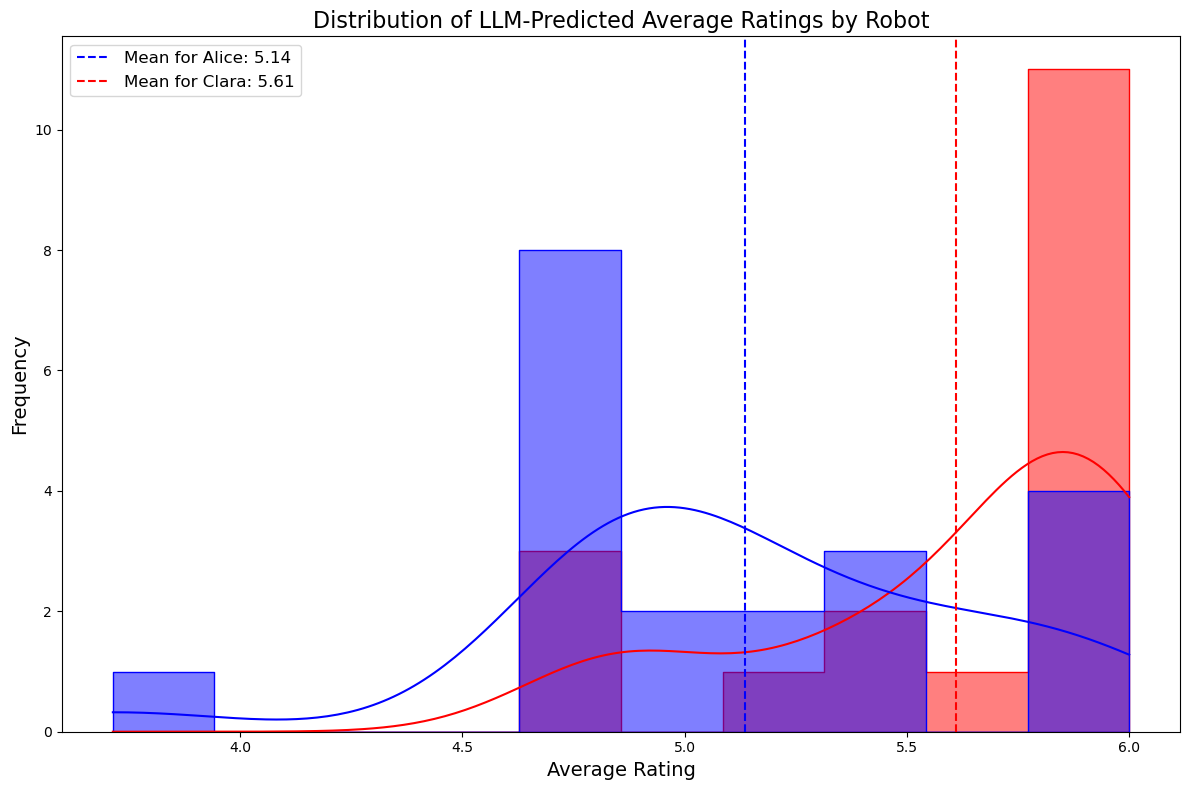

In [13]:
import os
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# *** MODIFIED: Corrected CCCLoss Implementation ***
def CCCLoss(x, y):
    """
    Calculates the Concordance Correlation Coefficient (CCC) Loss.
    CCC measures the agreement between two variables.
    Loss = 1 - CCC, because loss functions are minimized, while CCC is maximized.
    """

    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    # Ensure inputs are flat tensors
    x = x.view(-1)
    y = y.view(-1)

    # Calculate means
    mean_x = torch.mean(x)
    mean_y = torch.mean(y)

    # Calculate variances using population variance (unbiased=False)
    var_x = torch.var(x, unbiased=False)
    var_y = torch.var(y, unbiased=False)

    # Calculate covariance between x and y (population covariance)
    cov_xy = torch.mean((x - mean_x) * (y - mean_y))

    # Calculate CCC
    numerator = 2 * cov_xy
    denominator = var_x + var_y + (mean_x - mean_y)**2

    # Add a small epsilon for numerical stability (prevents division by zero)
    epsilon = 1e-8
    ccc = numerator / (denominator + epsilon)

    # Return 1 - CCC because loss functions should be minimized
    return 1.0 - ccc
# *** END MODIFICATION ***

# Create a dictionary to store the LLM predictions
llm_predictions = {}

user_reports_df = pd.read_excel("user-self-reports/target-enjoyment.xlsx", sheet_name='target-enjoyment', header=1)

# Loop through all the LLM prediction files in the Backup-gemini-2.5-pro directory
for filename in os.listdir("backup-11-speaker-gemini-2.0-flash-audio-text"):
    if not filename.endswith("-LLM-pred.txt"):
        continue
    
    # Extract participant ID from filename
    participant_id = int(re.search(r'P(\d+)', filename).group(1))
    
    # Read the file content
    with open(f"backup-11-speaker-gemini-2.0-flash-audio-text/{filename}", "r") as f:
        content = f.read()
    
    # Split the content by robot
    robot_sections = content.split("Robot: ")
    
    for section in robot_sections[1:]:  # Skip the first empty section
        lines = section.strip().split("\n", 1)
        if len(lines) < 2:
            continue
            
        robot_name = lines[0]

        if robot_name != user_reports_df.loc[user_reports_df['PID'] == participant_id, 'Q1-Robot'].values[0]:
            continue

        # Extract the response text
        response_text = lines[1].replace("Response: ", "")
        
        # Try to parse the JSON response
        try:
            # Extract JSON part if it exists
            json_match = re.search(r'(\{.*\})', response_text, re.DOTALL)
            if json_match:
                response_json = json.loads(json_match.group(1))
                
                # Create a dictionary for this participant and robot if it doesn't exist
                if participant_id not in llm_predictions:
                    llm_predictions[participant_id] = {}
                
                # Store the predictions
                llm_predictions[participant_id][robot_name] = response_json
        except Exception as e:
            print(f"Error parsing response for P{participant_id}, {robot_name}: {e}")

# Create a list to store the rows for the DataFrame
llm_data = []

# Iterate through each participant and their robot data
for participant_id, robots in llm_predictions.items():
    for robot, predictions in robots.items():
        # Create a row for this participant and robot
        row = {
            'user_id': participant_id,
            'robot': robot
        }
        
        # Add the predictions for each question
        for q_num in range(1, 8):
            question_key = f"Question {q_num}"
            if question_key in predictions:
                # For Q7 and Q8, we need to invert the scale (8 - value) to match the original data
                if q_num == 7 or q_num == 8:
                    row[f"Q{q_num}"] = 8 - predictions[question_key]
                else:
                    row[f"Q{q_num}"] = predictions[question_key]
            else:
                row[f"Q{q_num}"] = None
        
        llm_data.append(row)

# Create the DataFrame
llm_df = pd.DataFrame(llm_data)

# Calculate the average score for each participant and robot
llm_df["Average"] = llm_df.iloc[:, 2:10].mean(axis=1)

# Sort by user_id to make it easier to read
llm_df = llm_df.sort_values(by=['user_id', 'robot']).reset_index(drop=True)

# Display the DataFrame
print(llm_df.head(10))
print(f"Total number of records: {len(llm_df)}")

# Create a figure with bigger size
plt.figure(figsize=(12, 8))

# Create a distribution plot of the averages by robot type
ax = sns.histplot(data=llm_df, x='Average', hue='robot', kde=True, bins=10, 
                 element='step', palette=['blue', 'red'], alpha=0.5)

# Add a vertical line for the mean of each robot
for robot, color in zip(['Alice', 'Clara'], ['blue', 'red']):
    mean_val = llm_df[llm_df['robot'] == robot]['Average'].mean()
    plt.axvline(x=mean_val, color=color, linestyle='--', 
                label=f'Mean for {robot}: {mean_val:.2f}')

# Add titles and labels
plt.title('Distribution of LLM-Predicted Average Ratings by Robot', fontsize=16)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
# Save user id and average to a new CSV file
llm_df[["user_id", "Average"]].to_csv('predictions-llm.csv', index=False)

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr
import pandas as pd

# Merge the dataframes to compare LLM predictions with actual user ratings
# First, let's make sure the ordering is consistent by setting index as user_id and robot
ordered_df = pd.read_csv("y-enjoyment.csv", header=0)
ordered_df_indexed = ordered_df.set_index(['user_id', 'robot'])
llm_df_indexed = llm_df.set_index(['user_id', 'robot'])

# Find the common indices (user_id, robot combinations present in both datasets)
common_indices = ordered_df_indexed.index.intersection(llm_df_indexed.index)

# Filter both dataframes to only include common indices
ordered_filtered = ordered_df_indexed.loc[common_indices]
llm_filtered = llm_df_indexed.loc[common_indices]

# Calculate MSE for average ratings
mse = mean_squared_error(ordered_filtered['Average'], llm_filtered['Average'])
rmse = np.sqrt(mse)

# Calculate correlation and p-value for average ratings
average_correlation, average_p_value = pearsonr(ordered_filtered['Average'], llm_filtered['Average'])

# Print results
print(f"Mean Squared Error (MSE) between LLM and user average ratings: {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Correlation between LLM and user average ratings: {average_correlation:.4f}")
print(f"P-value for average correlation: {average_p_value:.4e}")
# Compute and print r2 score
r2 = r2_score(ordered_filtered['Average'], llm_filtered['Average'])
print(f"R^2 Score: {r2:.4f}")
# Compute and print CCC
ccc = 1 - CCCLoss(torch.tensor(ordered_filtered['Average'].values), torch.tensor(llm_filtered['Average'].values))
print(f"Concordance Correlation Coefficient (CCC): {ccc:.4f}")
# Compute and print MAE
mae = mean_absolute_error(ordered_filtered['Average'], llm_filtered['Average'])
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Squared Error (MSE) between LLM and user average ratings: 1.3534
Root Mean Squared Error (RMSE): 1.1634
Correlation between LLM and user average ratings: 0.5561
P-value for average correlation: 2.8931e-04
R^2 Score: 0.2756
Concordance Correlation Coefficient (CCC): 0.3645
Mean Absolute Error (MAE): 0.9474


/var/folders/ck/yx21ls8d6gl3n1j2pst19c1h0000gn/T/ipykernel_9353/2058021896.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/var/folders/ck/yx21ls8d6gl3n1j2pst19c1h0000gn/T/ipykernel_9353/2058021896.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
